In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import sklearn
from random import random 
from random import sample 
from scipy.stats import norm
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.utils import class_weight
from sklearn import svm, datasets
import matplotlib 

matplotlib.rc('font', **{'size'   : 16})

In [2]:
DATA = "../preprocessing/standardized_data.csv"
data = pd.read_csv(DATA,header=0)

## Again, reusing the misclassification definitions

In [3]:
def gender_misclassification(gt, prediction): 
    """Given a vector of ground truth values `gt` and a vector of prediction values `gt`, 
    return a vector containing 1 if there has been gender misclassification and 0 otherwise. """
    n = len(gt)
    assert(len(prediction) == n)
    result = np.zeros(n)
    for i in range(n): 
        # If the ground truth or the result from the API is "unsure", no misclassification
        if gt[i] == 0 or prediction[i] == 0: 
            result[i] = 0
        # If the ground truth does not match the prediction, set the misclassification bit to one. 
        elif gt[i] != prediction[i]: 
            result[i] = 1
        else: 
            result[i] = 0
    return result

In [4]:
def race_misclassification(gt, prediction): 
    """Given a vector of ground truth values `gt` and a vector of prediction values `gt`, 
    return a vector containing 1 if there has been race misclassification and 0 otherwise. """
    n = len(gt)
    assert(len(prediction) == n)
    result = np.zeros(n)
    for i in range(n): 
        # If the subjects is within a cornercase group or the prediction has outputed "not sure", then 
        # no misclassification
        if gt[i] in [0,5] or prediction[i] == 0 : 
            result[i] = 0
        # If the ground truth does not match the prediction, set the misclassification bit to one. 
        elif gt[i] != prediction[i]: 
            result[i] = 1
        else: 
            result[i] = 0
    return result

In [5]:
def age_misclassification(gt, prediction): 
    """Given a vector of ground truth values `gt` and a vector of prediction values `gt`, 
    return a vector containing 1 if there has been age misclassification and 0 otherwise. """
    n = len(gt)
    assert(len(prediction) == n)
    result = np.zeros(n)
    
    for i in range(n): 
        tolerance = 0 
        # If the subject is a child, tolerance interval equals 5
        if gt[i] <= 10: 
            tolerance = 5
        # For teenagers and pre-young-adults, tolerance is 10
        elif gt[i] <= 25: 
            tolerance = 10
        # For the rest of the population, tolerance is 15
        else: 
            tolerance = 15
            
        if gt[i] - tolerance <= prediction[i] <= gt[i] + tolerance: 
            result[i] = 0
        else: 
            result[i] = 1
    return result

In [6]:
def emotion_misclassification(gt, prediction): 
    """Given a vector of ground truth values `gt` and a vector of prediction values `gt`, 
    return a vector containing 1 if there has been emotion misclassification and 0 otherwise. """
    n = len(gt)
    assert(len(prediction) == n)
    result = np.zeros(n)
    
    for i in range(n): 
        # If dealing with one of the undefined emotions, set the misclassification bit to 0
        if gt[i] <= 0 or prediction[i] <= 0: 
            result[i] = 0 
        # If emotions don't match, set the misclassification bit to 1
        elif gt[i] != prediction[i]: 
            result[i] = 1
        else: 
            result[i] = 0
    return result

In [7]:
def recall(estimator, X, y): 
    """ Calculate the recall of the estimator predicting on inputs X with output labels y"""

    prediction = estimator.predict(X)
    
    y = np.array(y)
    prediction = np.array(prediction)
        
    tp = 0
    fn = 0
    
    for i in range(y.size): 
        if y[i] == 1 and prediction[i] == 1:
            tp += 1
            continue 
        if y[i] == 1 and prediction[i] == 0: 
            fn += 1
            
    return (tp / (tp + fn))

In [8]:
def precision(estimator, X, y):
    """ Calculate the precision of the estimator predicting on inputs X with output labels y"""
    
    prediction = estimator.predict(X)
    
    y = np.array(y)
    prediction = np.array(prediction)
    tp = 0
    fp = 0
    for i in range(y.size):
        if y[i] == 1 and prediction[i] == 1:
            tp += 1
            continue
        if y[i] == 0 and prediction[i] == 1:
            fp += 1
    return (tp / (tp + fp))

In [9]:
def plot_scores(model, data=None, outputs=None): 
    """Given a classifier, display the cross-validation score on data (by default X_scaled) using 
    expected_cost, recall, precision and accuracy and scoring functions.""" 
    if data is None: 
        data = X_scaled
    if outputs is None: 
        outputs = y 
    recall_scores = cross_val_score(model, data, outputs, cv=5, scoring=recall)
    precision_scores = cross_val_score(model, data, outputs, cv=5, scoring=precision)
    accuracy_scores = cross_val_score(model, data, outputs, cv=5, scoring="accuracy")

    rec = sum(recall_scores)/10 
    prec = sum(precision_scores)/10
    acc = sum(accuracy_scores)/10
    
    df = pd.DataFrame((rec, prec, acc), index=["Recall", "Precision", "Accuracy"], columns=["Performance"])
    return df

# Gender Misclassification

In [10]:
data_no_ai = data[data["Origin"] != "AI"]
gender_misclassification(data_no_ai["Gender"], data_no_ai["clarifai_gender"])

array([0., 0., 0., ..., 0., 0., 0.])

In [11]:
cl = gender_misclassification(data_no_ai["Gender"], data_no_ai["clarifai_gender"]) == 1
ms = gender_misclassification(data_no_ai["Gender"], data_no_ai["microsoft_gender"]) == 1
am = gender_misclassification(data_no_ai["Gender"], data_no_ai["amazon_gender"]) == 1
fa = gender_misclassification(data_no_ai["Gender"], data_no_ai["face++_gender"]) == 1

In [12]:
gender_misclass = (cl | ms | am |fa)
sum(gender_misclass)

372

In [13]:
X = data_no_ai[["Race", "Age", "Gender", "Emotion"]]
y = [int(x) for x in gender_misclass]

In [14]:
# One-hot encoding
X_eng = X.copy()

is_black = [int(x) for x in X_eng["Race"] == 2]
is_white = [int(x) for x in X_eng["Race"] == 4]
is_asian = [int(x) for x in X_eng["Race"] == 1]
is_latino = [int(x) for x in X_eng["Race"] == 3]
is_rest = [int(x) for x in X_eng["Race"] == 5]

is_happy = [int(x) for x in X_eng["Emotion"] == 5]
is_sad = [int(x) for x in X_eng["Emotion"] == 6]
is_calm = [int(x) for x in X_eng["Emotion"] == 2]
is_angry = [int(x) for x in X_eng["Emotion"] == 1]
is_fearful = [int(x) for x in X_eng["Emotion"] == 4]
is_surprised = [int(x) for x in X_eng["Emotion"] == 7]
is_disgusted = [int(x) for x in X_eng["Emotion"] == 3]

X_eng["is_black"] = is_black
X_eng["is_white"] = is_white
X_eng["is_asian"] = is_asian
X_eng["is_latino"] = is_latino
X_eng["is_rest"] = is_rest
X_eng["is_happy"] = is_happy
X_eng["is_sad"] = is_sad
X_eng["is_calm"] = is_calm
X_eng["is_angry"] = is_angry
X_eng["is_fearful"] = is_fearful
X_eng["is_surprised"] = is_surprised
X_eng["is_disgusted"] = is_disgusted

X = X_eng.drop(columns=["Race", "Emotion"])

In [15]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.15)

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
lr = LogisticRegression(solver='lbfgs') 

In [18]:
sum(cross_val_score(lr, X_train_scaled, y_train, cv=5))/5

0.8527186816803404

In [19]:
lr.fit(X_train_scaled, y_train)
prediction = lr.predict(X_test_scaled)

In [20]:
sum(prediction)

5

In [21]:
is_actually_misclass = np.array(y_test) == 1
is_not_misclass = np.array(y_test) == 0

In [22]:
sum(prediction[is_actually_misclass] == 1)/sum(is_actually_misclass)

0.07407407407407407

In [23]:
sum(prediction[is_not_misclass] == 0)/sum(is_not_misclass)

0.9967845659163987

In [24]:
def balanced_accuracy(estimator, X, y):
    """ Calculate the precision of the estimator predicting on inputs X with output labels y"""
    
    prediction = np.array(estimator.predict(X))
    y = np.array(y)
    
    is_actually_misclass = y == 1
    is_not_misclass = y == 0
    
    acc_for_1 = sum(prediction[is_actually_misclass] == 1)/sum(is_actually_misclass)
    acc_for_0 = sum(prediction[is_not_misclass] == 0)/sum(is_not_misclass)
    
    return (acc_for_0 + acc_for_1) / 2

In [25]:
lr = LogisticRegression(solver='lbfgs') 

In [26]:
sum(cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5

0.5388618530267886

In [27]:
res = []
best_weight = None 
best_score = 0 
for w in np.linspace(1,30,50): 
    lr_tune = LogisticRegression(solver='lbfgs', class_weight={0:1, 1:w})
    cv_score = sum(cross_val_score(lr_tune, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5
    if cv_score > best_score: 
        best_weight = w
        best_score = cv_score
    res.append(cv_score)

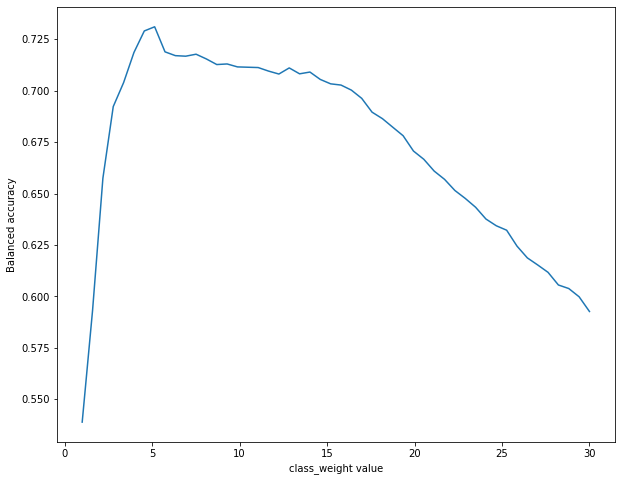

In [28]:
plt.figure(figsize=(10,8))
plt.plot(np.linspace(1,30,50), res)
plt.xlabel("class_weight value")
plt.ylabel("Balanced accuracy")
#plt.savefig('training.svg', format='svg')
plt.show()

In [29]:
print(best_weight)
print(best_score)

5.142857142857142
0.7310564168599627


In [30]:
lr_balanced = LogisticRegression(solver='lbfgs', class_weight={0:1, 1:best_weight}) 
sum(cross_val_score(lr_balanced, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5

0.7310564168599627

In [31]:
lr_balanced.fit(X_train_scaled, y_train)
balanced_prediction = lr_balanced.predict(X_test_scaled)

In [32]:
print("Accuracy for the 1-class")
print(1 - sum(abs(balanced_prediction[np.array(y_test) == 1] - 1))/sum(np.array(y_test) == 1))
print()
print("Accuracy for the 0-class")
print(1 - sum(abs(balanced_prediction[np.array(y_test) == 0] - 0))/sum(np.array(y_test) == 0))
print()
print("Balanced accuracy score: ")
print(balanced_accuracy(lr_balanced, X_test_scaled, y_test))
# Same as (acc_0 + acc_1)/2
print()
print("Weighted accuracy")
print(1 - sum(abs(balanced_prediction - y_test))/len(y_test))
print()
print("Recall")
print(recall(lr_balanced, X_test_scaled, y_test))
print()
print("Precision")
print(precision(lr_balanced, X_test_scaled, y_test))
print()

Accuracy for the 1-class
0.8703703703703703

Accuracy for the 0-class
0.6430868167202572

Balanced accuracy score: 
0.7567285935453139

Weighted accuracy
0.6767123287671233

Recall
0.8703703703703703

Precision
0.2974683544303797



In [33]:
print("We can see the most important factors for gender misclassification in out model are gender itself and age.")
lr_balanced.coef_

We can see the most important factors for gender misclassification in out model are gender itself and age.


array([[-0.35066593, -1.08245041,  0.16935904,  0.06980434, -0.02799082,
         0.0070433 , -0.21258617, -0.96068947, -0.19092362, -0.7144057 ,
        -0.39608864, -0.32136683, -0.05115786, -0.29386648]])

In [34]:
lr_balanced.intercept_

array([-0.56508562])

In [35]:
T = X.copy()

In [36]:
list(zip(X.columns, lr_balanced.coef_[0]))

[('Age', -0.3506659328748283),
 ('Gender', -1.0824504111423139),
 ('is_black', 0.1693590396230986),
 ('is_white', 0.06980433694670193),
 ('is_asian', -0.027990818547722156),
 ('is_latino', 0.0070433004185224265),
 ('is_rest', -0.2125861740691429),
 ('is_happy', -0.9606894726966855),
 ('is_sad', -0.1909236195112007),
 ('is_calm', -0.7144057037781095),
 ('is_angry', -0.39608863781517345),
 ('is_fearful', -0.3213668257782686),
 ('is_surprised', -0.0511578627166465),
 ('is_disgusted', -0.2938664788814188)]

# Race Misclassification 

In [37]:
data_no_ai = data[data["Origin"] != "AI"]

In [38]:
race_misclass = race_misclassification(data_no_ai["Race"], data_no_ai["clarifai_race"]) == 1
sum(race_misclass)

319

In [39]:
X = data_no_ai[["Race", "Age", "Gender", "Emotion"]]
y = [int(x) for x in race_misclass]

In [40]:
# One-hot encoding
X_eng = X.copy()

is_black = [int(x) for x in X_eng["Race"] == 2]
is_white = [int(x) for x in X_eng["Race"] == 4]
is_asian = [int(x) for x in X_eng["Race"] == 1]
is_latino = [int(x) for x in X_eng["Race"] == 3]
is_rest = [int(x) for x in X_eng["Race"] == 5]

is_happy = [int(x) for x in X_eng["Emotion"] == 5]
is_sad = [int(x) for x in X_eng["Emotion"] == 6]
is_calm = [int(x) for x in X_eng["Emotion"] == 2]
is_angry = [int(x) for x in X_eng["Emotion"] == 1]
is_fearful = [int(x) for x in X_eng["Emotion"] == 4]
is_surprised = [int(x) for x in X_eng["Emotion"] == 7]
is_disgusted = [int(x) for x in X_eng["Emotion"] == 3]

X_eng["is_black"] = is_black
X_eng["is_white"] = is_white
X_eng["is_asian"] = is_asian
X_eng["is_latino"] = is_latino
X_eng["is_rest"] = is_rest
X_eng["is_happy"] = is_happy
X_eng["is_sad"] = is_sad
X_eng["is_calm"] = is_calm
X_eng["is_angry"] = is_angry
X_eng["is_fearful"] = is_fearful
X_eng["is_surprised"] = is_surprised
X_eng["is_disgusted"] = is_disgusted

X = X_eng.drop(columns=["Race", "Emotion"])

In [41]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.15)

In [42]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [43]:
lr = LogisticRegression(solver='lbfgs') 

In [44]:
sum(cross_val_score(lr, X_train_scaled, y_train, cv=5))/5

0.8657984437810009

In [45]:
lr.fit(X_train_scaled, y_train)
prediction = lr.predict(X_test_scaled)

In [46]:
sum(prediction)

6

In [47]:
is_actually_misclass = np.array(y_test) == 1
is_not_misclass = np.array(y_test) == 0

In [48]:
sum(prediction[is_actually_misclass] == 1)/sum(is_actually_misclass)

0.047619047619047616

In [49]:
sum(prediction[is_not_misclass] == 0)/sum(is_not_misclass)

0.9876160990712074

In [50]:
def balanced_accuracy(estimator, X, y):
    """ Calculate the precision of the estimator predicting on inputs X with output labels y"""
    
    prediction = np.array(estimator.predict(X))
    y = np.array(y)
    
    is_actually_misclass = y == 1
    is_not_misclass = y == 0
    
    acc_for_1 = sum(prediction[is_actually_misclass] == 1)/sum(is_actually_misclass)
    acc_for_0 = sum(prediction[is_not_misclass] == 0)/sum(is_not_misclass)
    
    return (acc_for_0 + acc_for_1) / 2

In [51]:
lr = LogisticRegression(solver='lbfgs') 

In [52]:
sum(cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5

0.5487073590228372

In [53]:
res = []
best_weight = None 
best_score = 0 
for w in np.linspace(1,30,50): 
    lr_tune = LogisticRegression(solver='lbfgs', class_weight={0:1, 1:w})
    cv_score = sum(cross_val_score(lr_tune, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5
    if cv_score > best_score: 
        best_weight = w
        best_score = cv_score
    res.append(cv_score)

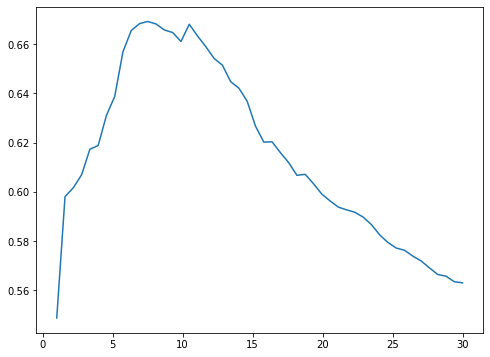

In [54]:
plt.figure(figsize=(8,6))
plt.plot(np.linspace(1,30,50), res)
plt.show()

In [55]:
print(best_weight)
print(best_score)

7.5102040816326525
0.6692163655711142


In [56]:
lr_balanced = LogisticRegression(solver='lbfgs', class_weight={0:1, 1:best_weight}) 
sum(cross_val_score(lr_balanced, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5

0.6692163655711142

In [57]:
lr_balanced.fit(X_train_scaled, y_train)
balanced_prediction = lr_balanced.predict(X_test_scaled)

In [58]:
print("Accuracy for the 1-class")
print(1 - sum(abs(balanced_prediction[np.array(y_test) == 1] - 1))/sum(np.array(y_test) == 1))
print()
print("Accuracy for the 0-class")
print(1 - sum(abs(balanced_prediction[np.array(y_test) == 0] - 0))/sum(np.array(y_test) == 0))
print()
print("Balanced accuracy score: ")
print(balanced_accuracy(lr_balanced, X_test_scaled, y_test))
# Same as (acc_0 + acc_1)/2
print()
print("Weighted accuracy")
print(1 - sum(abs(balanced_prediction - y_test))/len(y_test))
print()
print("Recall")
print(recall(lr_balanced, X_test_scaled, y_test))
print()
print("Precision")
print(precision(lr_balanced, X_test_scaled, y_test))
print()

Accuracy for the 1-class
0.7142857142857143

Accuracy for the 0-class
0.5294117647058824

Balanced accuracy score: 
0.6218487394957983

Weighted accuracy
0.5506849315068494

Recall
0.7142857142857143

Precision
0.16483516483516483



In [59]:
lr_balanced.coef_

array([[-0.10018866,  0.10331626,  0.0258366 ,  0.57000178, -0.296519  ,
         0.68360821, -0.19891243, -0.47195585, -0.1929815 , -0.48826278,
        -0.20032189, -0.42658922, -0.27821037, -0.23462004]])

In [60]:
lr_balanced.intercept_

array([-0.16883618])

In [61]:
T = X.copy()

In [62]:
list(zip(X.columns, lr_balanced.coef_[0]))

[('Age', -0.10018866246698434),
 ('Gender', 0.10331625598795922),
 ('is_black', 0.025836596837698726),
 ('is_white', 0.570001778829496),
 ('is_asian', -0.2965189960291528),
 ('is_latino', 0.6836082080993736),
 ('is_rest', -0.19891242862418318),
 ('is_happy', -0.47195585262615886),
 ('is_sad', -0.19298150017122515),
 ('is_calm', -0.4882627804942721),
 ('is_angry', -0.2003218881871493),
 ('is_fearful', -0.42658922333394644),
 ('is_surprised', -0.2782103685086516),
 ('is_disgusted', -0.2346200409048905)]

# Age Misclassification Model  

In [63]:
data_no_ai = data[data["Origin"] != "AI"]

In [64]:
cl = age_misclassification(data["Age"], data["clarifai_age"]) == 1
ms = age_misclassification(data["Age"], data["microsoft_age"]) == 1
am = age_misclassification(data["Age"], data["amazon_age_average"]) == 1
fa = age_misclassification(data["Age"], data["face++_age"]) == 1

In [65]:
age_misclass = (cl | ms | am |fa)
sum(age_misclass)

1060

In [66]:
len(data)

2677

In [67]:
X = data[["Race", "Age", "Gender", "Emotion"]]
y = [int(x) for x in age_misclass]

In [68]:
# One-hot encoding
X_eng = X.copy()

is_black = [int(x) for x in X_eng["Race"] == 2]
is_white = [int(x) for x in X_eng["Race"] == 4]
is_asian = [int(x) for x in X_eng["Race"] == 1]
is_latino = [int(x) for x in X_eng["Race"] == 3]
is_rest = [int(x) for x in X_eng["Race"] == 5]

is_happy = [int(x) for x in X_eng["Emotion"] == 5]
is_sad = [int(x) for x in X_eng["Emotion"] == 6]
is_calm = [int(x) for x in X_eng["Emotion"] == 2]
is_angry = [int(x) for x in X_eng["Emotion"] == 1]
is_fearful = [int(x) for x in X_eng["Emotion"] == 4]
is_surprised = [int(x) for x in X_eng["Emotion"] == 7]
is_disgusted = [int(x) for x in X_eng["Emotion"] == 3]

X_eng["is_black"] = is_black
X_eng["is_white"] = is_white
X_eng["is_asian"] = is_asian
X_eng["is_latino"] = is_latino
X_eng["is_rest"] = is_rest
X_eng["is_happy"] = is_happy
X_eng["is_sad"] = is_sad
X_eng["is_calm"] = is_calm
X_eng["is_angry"] = is_angry
X_eng["is_fearful"] = is_fearful
X_eng["is_surprised"] = is_surprised
X_eng["is_disgusted"] = is_disgusted

X = X_eng.drop(columns=["Race", "Emotion"])

In [69]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.15)

In [70]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [71]:
lr = LogisticRegression(solver='lbfgs') 

In [72]:
sum(cross_val_score(lr, X_train_scaled, y_train, cv=5))/5

0.6914285714285715

In [73]:
lr.fit(X_train_scaled, y_train)
prediction = lr.predict(X_test_scaled)

In [74]:
is_actually_misclass = np.array(y_test) == 1
is_not_misclass = np.array(y_test) == 0

In [75]:
sum(prediction[is_actually_misclass] == 1)/sum(is_actually_misclass)

0.4470588235294118

In [76]:
sum(prediction[is_not_misclass] == 0)/sum(is_not_misclass)

0.8189655172413793

In [77]:
def balanced_accuracy(estimator, X, y):
    """ Calculate the precision of the estimator predicting on inputs X with output labels y"""
    
    prediction = np.array(estimator.predict(X))
    y = np.array(y)
    
    is_actually_misclass = y == 1
    is_not_misclass = y == 0
    
    acc_for_1 = sum(prediction[is_actually_misclass] == 1)/sum(is_actually_misclass)
    acc_for_0 = sum(prediction[is_not_misclass] == 0)/sum(is_not_misclass)
    
    return (acc_for_0 + acc_for_1) / 2

In [78]:
lr = LogisticRegression(solver='lbfgs') 

In [79]:
sum(cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5

0.6507950350870076

In [80]:
res = []
best_weight = None 
best_score = 0 
for w in np.linspace(1,3,50): 
    lr_tune = LogisticRegression(solver='lbfgs', class_weight={0:1, 1:w})
    cv_score = sum(cross_val_score(lr_tune, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5
    if cv_score > best_score: 
        best_weight = w
        best_score = cv_score
    res.append(cv_score)

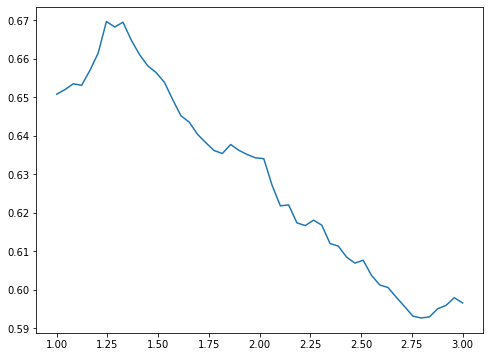

In [81]:
plt.figure(figsize=(8,6))
plt.plot(np.linspace(1,3,50), res)
plt.show()

In [82]:
print(best_weight)
print(best_score)

1.2448979591836735
0.6696730621019754


In [83]:
lr_balanced = LogisticRegression(solver='lbfgs', class_weight={0:1, 1:best_weight}) 
sum(cross_val_score(lr_balanced, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5

0.6696730621019754

In [84]:
lr_balanced.fit(X_train_scaled, y_train)
balanced_prediction = lr_balanced.predict(X_test_scaled)

In [85]:
print("Accuracy for the 1-class")
print(1 - sum(abs(balanced_prediction[np.array(y_test) == 1] - 1))/sum(np.array(y_test) == 1))
print()
print("Accuracy for the 0-class")
print(1 - sum(abs(balanced_prediction[np.array(y_test) == 0] - 0))/sum(np.array(y_test) == 0))
print()
print("Balanced accuracy score: ")
print(balanced_accuracy(lr_balanced, X_test_scaled, y_test))
# Same as (acc_0 + acc_1)/2
print()
print("Weighted accuracy")
print(1 - sum(abs(balanced_prediction - y_test))/len(y_test))
print()
print("Recall")
print(recall(lr_balanced, X_test_scaled, y_test))
print()
print("Precision")
print(precision(lr_balanced, X_test_scaled, y_test))
print()

Accuracy for the 1-class
0.5823529411764705

Accuracy for the 0-class
0.6896551724137931

Balanced accuracy score: 
0.636004056795132

Weighted accuracy
0.6442786069651741

Recall
0.5823529411764706

Precision
0.5789473684210527



In [86]:
lr_balanced.coef_

array([[-0.43475856, -0.2143026 ,  0.21419115,  0.32646662,  0.05116573,
         0.19142141, -0.14170984, -0.0238647 ,  0.02651943, -0.45974629,
         0.08273024,  0.0136182 , -0.21728823,  0.21655404]])

In [87]:
lr_balanced.intercept_

array([-0.29243129])

In [88]:
T = X.copy()

In [89]:
list(zip(X.columns, lr_balanced.coef_[0]))

[('Age', -0.434758562658544),
 ('Gender', -0.21430260198094342),
 ('is_black', 0.21419114988715135),
 ('is_white', 0.3264666248745681),
 ('is_asian', 0.05116573019588018),
 ('is_latino', 0.19142140952796935),
 ('is_rest', -0.14170984441549064),
 ('is_happy', -0.023864702613399253),
 ('is_sad', 0.026519428563402288),
 ('is_calm', -0.45974629283594626),
 ('is_angry', 0.08273023660432746),
 ('is_fearful', 0.013618201618891096),
 ('is_surprised', -0.21728822802982636),
 ('is_disgusted', 0.21655404498301334)]

# Emotion Misclassification

In [90]:
data_no_ai = data[data["Origin"] != "AI"]

In [91]:
ms = emotion_misclassification(data_no_ai["Emotion"], data_no_ai["microsoft_emotion"]) == 1
am = emotion_misclassification(data_no_ai["Emotion"], data_no_ai["amazon_emotion"]) == 1
fa = emotion_misclassification(data_no_ai["Emotion"], data_no_ai["face++_emotion"]) == 1

In [92]:
emotion_misclass = (ms | am | fa)

In [93]:
X = data_no_ai[["Race", "Age", "Gender", "Emotion"]]
y = [int(x) for x in emotion_misclass]

In [94]:
# One-hot encoding
X_eng = X.copy()

is_black = [int(x) for x in X_eng["Race"] == 2]
is_white = [int(x) for x in X_eng["Race"] == 4]
is_asian = [int(x) for x in X_eng["Race"] == 1]
is_latino = [int(x) for x in X_eng["Race"] == 3]
is_rest = [int(x) for x in X_eng["Race"] == 5]

is_happy = [int(x) for x in X_eng["Emotion"] == 5]
is_sad = [int(x) for x in X_eng["Emotion"] == 6]
is_calm = [int(x) for x in X_eng["Emotion"] == 2]
is_angry = [int(x) for x in X_eng["Emotion"] == 1]
is_fearful = [int(x) for x in X_eng["Emotion"] == 4]
is_surprised = [int(x) for x in X_eng["Emotion"] == 7]
is_disgusted = [int(x) for x in X_eng["Emotion"] == 3]

X_eng["is_black"] = is_black
X_eng["is_white"] = is_white
X_eng["is_asian"] = is_asian
X_eng["is_latino"] = is_latino
X_eng["is_rest"] = is_rest
X_eng["is_happy"] = is_happy
X_eng["is_sad"] = is_sad
X_eng["is_calm"] = is_calm
X_eng["is_angry"] = is_angry
X_eng["is_fearful"] = is_fearful
X_eng["is_surprised"] = is_surprised
X_eng["is_disgusted"] = is_disgusted

X = X_eng.drop(columns=["Race", "Emotion"])

In [95]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.15)

In [96]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [97]:
lr = LogisticRegression(solver='lbfgs') 

In [98]:
sum(cross_val_score(lr, X_train_scaled, y_train, cv=5))/5

0.7713216107571875

In [99]:
lr.fit(X_train_scaled, y_train)
prediction = lr.predict(X_test_scaled)

In [100]:
def balanced_accuracy(estimator, X, y):
    """ Calculate the precision of the estimator predicting on inputs X with output labels y"""
    
    prediction = np.array(estimator.predict(X))
    y = np.array(y)
    
    is_actually_misclass = y == 1
    is_not_misclass = y == 0
    
    acc_for_1 = sum(prediction[is_actually_misclass] == 1)/sum(is_actually_misclass)
    acc_for_0 = sum(prediction[is_not_misclass] == 0)/sum(is_not_misclass)
    
    return (acc_for_0 + acc_for_1) / 2

In [101]:
lr = LogisticRegression(solver='lbfgs') 

In [102]:
sum(cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5

0.729928198810334

In [103]:
res = []
best_weight = None 
best_score = 0 
for w in np.linspace(1,30,50): 
    lr_tune = LogisticRegression(solver='lbfgs', class_weight={0:1, 1:w})
    cv_score = sum(cross_val_score(lr_tune, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5
    if cv_score > best_score: 
        best_weight = w
        best_score = cv_score
    res.append(cv_score)

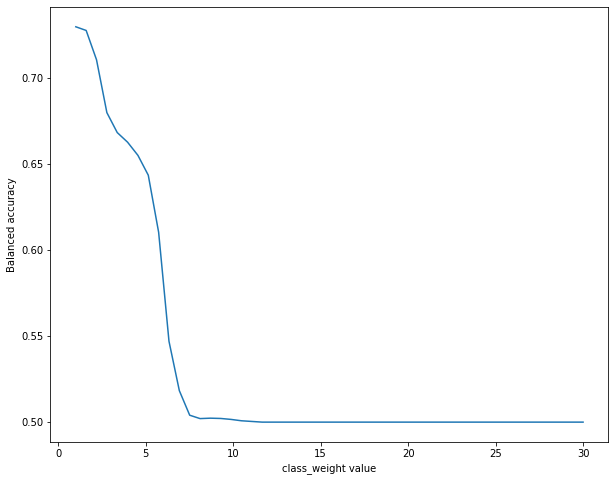

In [104]:
plt.figure(figsize=(10,8))
plt.plot(np.linspace(1,30,50), res)
plt.xlabel("class_weight value")
plt.ylabel("Balanced accuracy")
#plt.savefig('training.svg', format='svg')
plt.show()

In [105]:
print(best_weight)
print(best_score)

1.0
0.729928198810334


In [106]:
lr_balanced = LogisticRegression(solver='lbfgs', class_weight={0:1, 1:best_weight}) 
sum(cross_val_score(lr_balanced, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5

0.729928198810334

In [107]:
lr_balanced.fit(X_train_scaled, y_train)
balanced_prediction = lr_balanced.predict(X_test_scaled)

In [108]:
print("Accuracy for the 1-class")
print(1 - sum(abs(balanced_prediction[np.array(y_test) == 1] - 1))/sum(np.array(y_test) == 1))
print()
print("Accuracy for the 0-class")
print(1 - sum(abs(balanced_prediction[np.array(y_test) == 0] - 0))/sum(np.array(y_test) == 0))
print()
print("Balanced accuracy score: ")
print(balanced_accuracy(lr_balanced, X_test_scaled, y_test))
# Same as (acc_0 + acc_1)/2
print()
print("Weighted accuracy")
print(1 - sum(abs(balanced_prediction - y_test))/len(y_test))
print()
print("Recall")
print(recall(lr_balanced, X_test_scaled, y_test))
print()
print("Precision")
print(precision(lr_balanced, X_test_scaled, y_test))
print()

Accuracy for the 1-class
0.5619834710743802

Accuracy for the 0-class
0.8975409836065573

Balanced accuracy score: 
0.7297622273404688

Weighted accuracy
0.7863013698630137

Recall
0.5619834710743802

Precision
0.7311827956989247

